In [13]:
pip install d2l

  Using cached d2l-1.0.3-py3-none-any.whl.metadata (556 bytes)
  Using cached jupyter-1.0.0-py2.py3-none-any.whl.metadata (995 bytes)
  Using cached matplotlib-3.7.2-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached pandas-2.0.3-cp311-cp311-win_amd64.whl.metadata (18 kB)
  Using cached notebook-7.4.5-py3-none-any.whl.metadata (10 kB)
  Using cached qtconsole-5.7.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
  Using cached contourpy-1.3.2-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached beauti


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\decoH\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
pip install torchvision

  Using cached torchvision-0.23.0-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
Using cached torchvision-0.23.0-cp311-cp311-win_amd64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\decoH\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\decoH\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import torch

from d2l import torch as d2l

In [3]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Coursâ€¯!
Run!	Courezâ€¯!
Who?	Qui ?
Wow!	Ã‡a alo


In [4]:
#@save
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	coursâ€¯ !
run !	courezâ€¯ !
who ?	qui ?
wow !	ã‡a 


In [5]:
#@save
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['coursâ€¯', '!'],
  ['courezâ€¯', '!'],
  ['qui', '?'],
  ['ã‡a', 'alorsâ€¯', '!']])

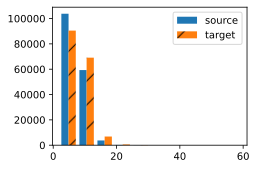

In [6]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [7]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10014

In [8]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [9]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [10]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [11]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[ 63, 114,   2,   4,   5,   5,   5,   5],
        [ 59, 157,  19,   2,   4,   5,   5,   5]], dtype=torch.int32)
valid lengths for X: tensor([4, 5])
Y: tensor([[170,  32,   1,   5,   6,   6,   6,   6],
        [180,  24, 107,   1,   5,   6,   6,   6]], dtype=torch.int32)
valid lengths for Y: tensor([4, 5])


### 9.5.7. Exercícios

1. Tente valores diferentes do argumento num_examples na funçãoload_data_nmt. Como isso afeta os tamanhos do vocabulário do idioma de origem e do idioma de destino?

In [12]:
for num_examples in [100, 300, 600, 1000]:
    _, src_vocab_tmp, tgt_vocab_tmp = load_data_nmt(batch_size=2, num_steps=8, num_examples=num_examples)
    print(f'num_examples={num_examples}: src_vocab={len(src_vocab_tmp)}, tgt_vocab={len(tgt_vocab_tmp)}')

num_examples=100: src_vocab=40, tgt_vocab=37
num_examples=300: src_vocab=102, tgt_vocab=103
num_examples=600: src_vocab=184, tgt_vocab=195
num_examples=1000: src_vocab=266, tgt_vocab=313


Quanto maior o valor de `num_examples` passado para `load_data_nmt`, mais frases são usadas para construir os vocabulários `src_vocab` e `tgt_vocab`. Isso faz com que os tamanhos dos vocabulários aumentem, pois mais palavras diferentes aparecem no conjunto de dados. Com menos exemplos, menos palavras distintas são vistas, resultando em vocabulários menores.

2. O texto em alguns idiomas, como chinês e japonês, não tem indicadores de limite de palavras (por exemplo, espaço). A tokenização em nível de palavra ainda é uma boa ideia para esses casos? Por que ou por que não

Em idiomas como chinês e japonês, não há espaços para separar palavras, então a tokenização em nível de palavra não é uma boa ideia sem um pré-processamento específico. Nesses casos, é comum usar tokenização em nível de caractere ou aplicar algoritmos de segmentação de palavras, pois a separação correta depende do contexto e do significado. A tokenização em nível de palavra pode causar erros de segmentação e dificultar o processamento do texto nesses idiomas.